# Cartpole: for newcomers to RL

We will be working through the methods described in the [OpenAI Requests for Research][1] for the [Cartpole environment][2]. 

Specifically, we will start with a simple linear model (that has only four parameters), and use the sign of the weighted sum to choose between the two actions. We will then look at three methods for finding the best parameters:
  1. The random guessing algorithm
  2. The hill-climbing algorithm
  3. Policy gradient algorithm


[1]: https://openai.com/requests-for-research/#cartpole
[2]: https://gym.openai.com/envs/CartPole-v0/

## The Environment
> The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. 

> CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials.

## The Random Guessing Algorithm
> Generate 10,000 random configurations of the model's parameters, and pick the one that achieves the best cumulative reward. It is important to choose the distribution over the parameters correctly

### Find optimal parameters

In [6]:
import gym
import numpy as np

In [7]:
def run_episode(env, params):
    total_reward = 0
    num_timesteps = 200
    
    observation = env.reset()
    for _ in xrange(num_timesteps):
        action = 0 if np.matmul(params,observation) < 0 else 1
        observation, reward, done, info = env.step(action)
        total_reward += reward
        
        if done:
            break    
    return total_reward


def random_params():
    num_params = 4
    return 2 * np.random.random(size=num_params) - 1

In [8]:
# Find optimal parameters
env = gym.make('CartPole-v0')

num_episodes = 10000
num_params = 4

best_total_reward = 0
best_params = None

for _ in range(num_episodes):
    params = random_params()
    total_reward = run_episode(env, params)
    
    if total_reward > best_total_reward:
        best_total_reward = total_reward
        best_params = params
                
print "best total reward: {}\nbest parameters: {}\n".format(best_total_reward, best_params)

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
best total reward: 200.0
best parameters: [0.20483889 0.73917253 0.74116657 0.52343545]



### Watch result

In [4]:
import os
import os.path

from gym.wrappers import Monitor
from IPython.display import HTML

In [5]:
# Log an epsiode with the best params.
# https://discuss.openai.com/t/how-to-capture-video-feed-from-a-universe-game/954/2
dir_path = 'random/'
env = Monitor(env, dir_path, force=True)
run_episode(env, best_params)
env.close()

In [6]:
# Get the video file path.
for f in os.listdir(dir_path):
    _, extension = os.path.splitext(f)
    if extension == '.mp4':
        video_path = os.path.join(dir_path, f)

In [7]:
# Render the video inline.
# https://gist.github.com/thanasi/ad31f798b747629e717bcebd2cad15cf
html_str = """
<div align="middle">
<video width="80%" controls>
    <source src="{}" type="video/mp4">
</video></div>
"""
html_str = html_str.format(video_path)
HTML(html_str)

### How efficient is this?

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def plot(episode_counts, title=None):
    # https://stackoverflow.com/questions/5498008/pylab-histdata-normed-1-normalization-seems-to-work-incorrect
    num_experiments = len(episode_counts)
    weights = np.ones(num_experiments) / float(num_experiments)
    plt.hist(episode_counts, normed=0, weights=weights);
    
    plt.title(title);
    plt.xlabel('Episodes');
    plt.ylabel('Frequency');

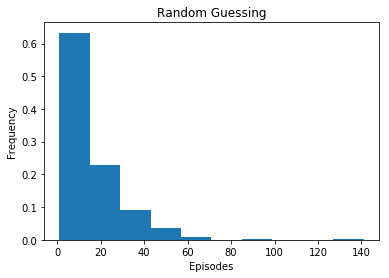

In [14]:
num_experiments = 1000
perfect_score = 200
episode_counts = []

for _ in xrange(num_experiments):
    for i in range(1, num_episodes + 1):
        params = random_params()
        total_reward = run_episode(env, params)
        
        if total_reward == perfect_score:
            break
            
    episode_counts.append(i)

plot(episode_counts, title='Random Guessing')

In a majority of the experiments, we are able to find parameters, which give us a perfect score for a single episode, in l0 episodes or less.

## The Hill-Climbing Algorithm
> Start with a random setting of the parameters, add a small amount of noise to the parameters, and evaluate the new parameter configuration. If it performs better than the old configuration, discard the old configuration and accept the new one. Repeat this process for some number of iterations. How long does it take to achieve perfect performance?

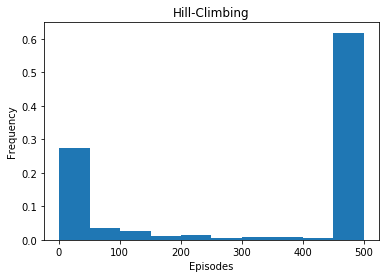

In [15]:
num_episodes = 500
noise_scale = 0.1
episode_counts = []

for j in xrange(num_experiments):
    params = random_params()
    reward = run_episode(env, params)
    
    for i in xrange(1, num_episodes + 1):
        noise = noise_scale * random_params()
        noise_reward = run_episode(env, params + noise)
        
        if noise_reward > reward:
            reward = noise_reward
            params += noise
        
        if reward == perfect_score:
            break
            
    episode_counts.append(i)

plot(episode_counts, title='Hill-Climbing')

Most of our experiments never achieve a perfect score because they get stuck at some point where changing it slighlty yields no improvement in reward.

# References:

  * [OpenAI docs][1]
  * [OpenAI ROR: Cartpole][2]
  * [KVFrans Cartpole blog post][3]
  * [OpenAI Gym repo][4]
  * [Cartpole-v0 environment doc][5]
  
  
[1]: https://gym.openai.com/docs/
[2]: https://openai.com/requests-for-research/#cartpole
[3]: http://kvfrans.com/simple-algoritms-for-solving-cartpole/
[4]: https://github.com/openai/gym
[5]: https://gym.openai.com/envs/CartPole-v0/